In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
'''p02-109-01-00 too long
r06-022-03-05 bad_img
a01-117-05-02'''

'p02-109-01-00 too long\nr06-022-03-05 bad_img\na01-117-05-02'

In [3]:
def prepare_dataset(paths):
    paths=paths[1:]
    labels = pd.read_csv('/kaggle/input/words-label/words.txt',sep='\n')[15:]
    
    idd=labels['#--- words.txt ---------------------------------------------------------------#'].apply(lambda x:(x.split()[0])).values
    lab = labels['#--- words.txt ---------------------------------------------------------------#'].apply(lambda x:(x.split()[-1]).lower()).values
    
    
    targets = dict(zip(idd,lab))
    
    characters = set((''.join(lab)).lower())
    word_ind = dict(zip(['<PAD>','<START>','<END>','<SPECIAL>']+sorted(list(characters)),range(len(characters)+4)))
    
    labell = [x.split('/')[-1][:-4] for x in paths]    
    return dict(zip(labell,paths)),targets,list(targets.keys())[1:],word_ind

In [4]:
from fastai.vision import *

import random
import time
import os
import scipy 
import scipy.io
import sys
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split


In [49]:
class CaltechDataset(Dataset):
    def __init__(self, imgs,dict_labels,name_ind,word_ind,transforms=None):
        # path to the dataset
        self.dict_labels=dict_labels
        # transformation for image and targets
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs
        self.name_ind=name_ind
        self.word_ind = word_ind
    def __getitem__(self, idx):
        if self.name_ind[idx]  in ['p02-109-01-00','r06-022-03-05','a01-117-05-02','p03-158-01-09']:
            print('bad')
            return torch.zeros((3,125,250)),torch.tensor([0]*60),'ww',torch.tensor(1)    
        else:
            img = cv2.imread(self.imgs[self.name_ind[idx]])
        targ = self.dict_labels[self.name_ind[idx]]
        
        res = []#[self.word_ind['<START>']]
        prev = ''
        for x in targ:
            if prev==x:
                res.append(self.word_ind['<SPECIAL>'])
            res.append(self.word_ind[x])
            prev=x
        res.append(self.word_ind['<END>'])
      
        sent_len = len(res)
        res+=[self.word_ind['<PAD>']]*(60-len(res))
        if self.transforms is not None:
            img= self.transforms(PIL.Image.fromarray(np.uint8(img)))
        return img, torch.tensor(res),targ,sent_len

    def __len__(self):
        '''this method return len of dataset'''
        return len(self.name_ind)

In [50]:
size = (125,250)
train_size = 0.9 
trans=transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor() # converts to [0,1] interval
])

imgs,dict_labels,name_ind,word_ind = prepare_dataset(paths)

train_inds=int(len(name_ind)*train_size)

random.shuffle(name_ind)

train_ds = CaltechDataset(imgs,dict_labels,name_ind[:train_inds],word_ind,transforms=trans)
val_ds = CaltechDataset(imgs,dict_labels,name_ind[train_inds:],word_ind,transforms=trans)


In [7]:
ar=[]

tensor([35, 44, 47,  2]) for 4


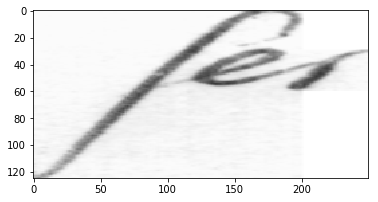

In [51]:
for i,x in enumerate(val_ds):
    if i==2:
        plt.imshow(x[0].permute(1,2,0))
        print(x[1][:x[3]],x[2],x[3])
        break   

In [52]:

def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)
act_fn = nn.ReLU(inplace=True)
def init_cnn(m):
    if getattr(m,'bias',None) is not None : nn.init.constant_(m.bias,0)
    if isinstance(m,(nn.Conv2d,nn.Linear)) : nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
    
def conv_layer(ni,nf,ks=3,stride=1,zero_bn=False,act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight,0 if zero_bn else 1.)
    layers = [conv(ni,nf,ks,stride=stride),bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)    
class ResBlock(nn.Module):
    def __init__(self,expansion,ni,nh,stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers = [conv_layer(ni,nh,1)]
        layers +=[conv_layer(nh,nf,3,stride=stride,zero_bn=True,act=False)
                 ]  if expansion==1 else [
            conv_layer(nh,nh,3,stride=stride),
            conv_layer(nh,nf,1,zero_bn=True,act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni,nf,1,act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True)
    def forward(self,x): return act_fn(self.convs(x)+self.idconv(self.pool(x)))
class XResNet(nn.Sequential):
    @classmethod
    def create(cls,expansion,layers,c_in=3,c_out = 1000):
        nfs = [c_in,(c_in+1)*8,64,64]
        stem = [conv_layer(nfs[i],nfs[i+1],stride=2 if i==0 else 1)
               for i in range(3)]
        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion,nfs[i],nfs[i+1],
                                     n_blocks=l,stride=1 if i==0 else 2)
                     for i,l in enumerate(layers)]
        res = cls(
                *stem,
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
                 *res_layers)
        init_cnn(res)
        return res
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [53]:

def xresnet18 (**kwargs): return XResNet.create(1, [2, 2, 2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4, 6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4, 6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [54]:
xresnet34()(torch.rand(2,3,125,250)).size()

torch.Size([2, 512, 4, 8])

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        self.conv0 = nn.Conv2d(3,64,5)
        self.conv1 = nn.Conv2d(64,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.conv3 = nn.Conv2d(64,64,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.conv5 = nn.Conv2d(128,128,3,padding=1)
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)
        self.batch1 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(64)
        self.batch4 = nn.BatchNorm2d(128)
        self.batch5 = nn.BatchNorm2d(128)
        self.batch6 = nn.BatchNorm2d(128)'''
        self.base = xresnet34()
        
        #-------------------
        #self.init_h =nn.Linear(30*61,256)
        #self.init_c=nn.Linear(30*61,256)
        self.before_lstm = nn.Linear(30*61*4,64)
        self.LSTM = nn.LSTM(128,256,bidirectional=True)
        self.output_layer = nn.Linear(2*256,56)
    def base1(self,x):
        x0=F.max_pool2d(F.relu(self.conv0(x)),2)
        x1=self.batch1(F.relu(self.conv1(x0)))
        x2=self.batch2(F.relu(self.conv2(x1)))
        x3=self.batch3(F.relu(self.conv3(x2)))
        x4=F.max_pool2d(self.batch4(F.relu(self.conv4(torch.cat((x3,x1),dim=1)))),2)
        x5=self.batch5(F.relu(self.conv5(x4)))
        x6=self.batch6(F.relu(self.conv6(x5)))
        x7=F.relu(self.conv7(torch.cat((x6,x4),dim=1)))
        return x7
    def init_hidden(self,base_out):
        #hidden = base_out.mean(dim=1).view(-1,30*61)
        #h = self.init_h(hidden)  # (batch_size, decoder_dim)
        #c = self.init_c(hidden)
        bs = base_out.size(0)
        h = base_out.view(bs,256,64).mean(dim=2)
        c = base_out.view(bs,256,64).mean(dim=2)

        return torch.cat((h.unsqueeze(0),h.unsqueeze(0)),dim=0), torch.cat((c.unsqueeze(0),c.unsqueeze(0)),dim=0)
    def forward(self,x):
        base_out=self.base(x)
        hidden = self.init_hidden(base_out)
        #in_lstm=self.before_lstm(base_out.view(base_out.size(0),64,-1))
        in_lstm =base_out.view(base_out.size(0),128,128)
        hidden = self.LSTM(in_lstm.permute(2,0,1),hidden)
        out = F.log_softmax(self.output_layer(hidden[0]),dim=2)
        
        return out    

In [56]:
loader = DataLoader(train_ds, batch_size=12,drop_last=True)
model = Net()
for X,Y,W,E in loader:
    print(E.max())
    break

tensor(8)


In [57]:
model(torch.rand(2,3,125,250)).size()

torch.Size([128, 2, 56])

In [58]:

train_loader = DataLoader(train_ds, batch_size=64,drop_last=True,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64,drop_last=True,shuffle=True)

epochs = 20

device = torch.device("cuda")
model = Net()
# state = torch.load('loc.pth')
# model.load_state_dict(state)
model = model.to(device)
# we optimizing parameters of our model, other parameters will not be optimised if exist  
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_ctc = torch.nn.CTCLoss(zero_infinity=True)

In [15]:
paths[-2:]

['/kaggle/input/words-label/words.txt', '/kaggle/input/mymodel/net_40_epochs_']

In [59]:
PATH='/kaggle/input/mymodel/net_40_epochs_'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [43]:
model=model.to(device)

In [74]:
def metric(target,preds):
    mask = np.zeros(preds.size()[:2])
    arr=preds.argmax(2).numpy().transpose()
    for i in range(mask.shape[0]-1):
        mask[i]=arr[:,i]==arr[:,i+1]
    preds = arr[(mask!=1).transpose()]
    preds_ind=np.where(preds==2)
    target=target[(target!=0)]
    targ_ind=np.where(target==2)
    accuracy = []
    prev_t = 1
    prev_p = 1
    for ti,pi in zip(targ_ind[0],preds_ind[0]):
        prr=preds[prev_p:pi]
        prr=prr[prr!=0]
        if len(prr)==len(target[prev_t:ti]):
            accuracy.append(np.mean(prr==target[prev_t:ti].numpy()))            
        else:
            accuracy.append(0)
        prev_t=ti+1
        prev_p=pi+1
    accuracy = np.array(accuracy)
    accuracy[np.isnan(np.array(accuracy))]=0
    return np.mean(accuracy)
def step(loader,is_train,metric=metric):
    model.train() if is_train else model.eval()
    losses=[]
    metrics=[0]
    for i, (img, target,word,lns) in enumerate(loader):
        img = img.to(device)
        target = target.to(device)
        lengths = lns.to(device)
        optimizer.zero_grad()
        outputs= model(img)    
        loss = loss_ctc(outputs,target, torch.full(size=(64,), fill_value=128, dtype=torch.long),lengths)   
        if is_train:
            # calculating gradients
            loss.backward()
            # optimizing
            optimizer.step()
        # .item() is simple way to get value from scalar
        else:
            metrics.append(metric(target.cpu(),outputs.cpu()))
        losses.append(loss.item())
    return np.mean(losses),np.mean(metrics)

In [75]:
%%time
model.train()
for e in range(20):    
    loss_tr,_= step(train_loader,is_train=True)
    loss_val,loss_metric = step(val_loader,is_train=False)
    print(e,'Loss train ',loss_tr,'val',loss_val,'metric',loss_metric)

bad
bad
bad
bad
0 Loss train  0.10334616822157834 val 0.1653588712008463 metric 0.8702955167626264
bad
bad
bad
bad
1 Loss train  0.0904818606516375 val 0.16163770306027597 metric 0.8812277558997171
bad
bad
bad
bad
2 Loss train  0.0789059962873921 val 0.16417384751968914 metric 0.8797796895496309
bad
bad
bad
bad
3 Loss train  0.07345665354146073 val 0.18008015209601985 metric 0.8675561654908166


KeyboardInterrupt: 

In [ ]:
from IPython.display import FileLink
torch.save(model.state_dict(),'net_40_epochs')
FileLink(r'net_40_epochs')

In [33]:
for i, (img, target,word,lns) in enumerate(loader):
    break

In [73]:
step(val_loader,is_train=False)

(0.13193314008207785, 0.8938127985715175)

In [34]:
model.eval()
model.to(torch.device('cpu'))
w=model(img.cpu())

In [35]:
target[:,:14]

tensor([[30, 41, 42, 44, 48, 49,  2,  0,  0,  0,  0,  0,  0,  0],
        [30, 49,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [45, 30, 47, 49, 38, 34, 48,  2,  0,  0,  0,  0,  0,  0],
        [15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30, 47, 34,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30, 49,  3, 49, 47, 30, 32, 49,  2,  0,  0,  0,  0,  0],
        [30, 43, 54,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [32, 44, 42,  3, 42, 30, 43, 33,  2,  0,  0,  0,  0,  0],
        [44, 35,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [45, 37, 38, 41, 45, 44, 49,  2,  0,  0,  0,  0,  0,  0],
        [52, 44, 47, 41, 33,  2,  0,  0,  0,  0,  0,  0,  0,  0]])

In [38]:
metric(target,w)

[49 42 44 48 49  0] tensor([41, 42, 44, 48, 49])
[30  0 49  0] tensor([30, 49])
[13  0] tensor([5])
[45  0 30 47 49 38 34 48  0] tensor([45, 30, 47, 49, 38, 34, 48])
[15  0] tensor([15])
[30  0 47 34  0] tensor([30, 47, 34])
[30 49  3 49 47 30 32 49  0] tensor([30, 49,  3, 49, 47, 30, 32, 49])
[32 44 42  3 42 30 43 33  0] tensor([32, 44, 42,  3, 42, 30, 43, 33])
[44 35  0] tensor([44, 35])
[45 37 38 41 45 44 47  0] tensor([45, 37, 38, 41, 45, 44, 49])
[52  0 44 47 41 33  0] tensor([52, 44, 47, 41, 33])
[0.8, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0.8571428571428571, 1.0]


0.8047619047619047

In [ ]:
Y[:10,:10]

In [ ]:
beam_search_decoder(w[:,-3,:].softmax(dim=1).detach().numpy(),2)

In [ ]:
from math import log
from numpy import array
from numpy import argmax
 
# beam search
def beam_search_decoder(data, k):
	sequences = [[list(), 1.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score * -log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

In [ ]:
for i in range(10):
    qe=w[:,i,:].exp().argmax(dim=1)
    print(qe[qe!=0])